In [1]:
# Import necessary packages
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# Define file path for storing cleaned data
file_path = "/Users/maxwellcozean/Desktop/ECON 1680/Machine Learning Project/Data"

# Define file path for storing figures
output_path = "/Users/maxwellcozean/Desktop/ECON 1680/Machine Learning Project/Output"

# Join paths and import csv as dataframe
df = pd.read_csv(os.path.join(file_path,"Most-Recent-Cohorts-Institution_cleaned.csv"),
                 encoding='utf-8',low_memory=False)

In [3]:
# Specify output variable
y = df['CDR2']

# Specify input variables
X = df.drop(columns=['CDR2'])

# Create training and testing splits of the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1680)

In [4]:
# Run a preliminary OLS regression on the training data
olsReg = sm.OLS(y_train, X_train).fit()

# Run OLS model on testing set
y_pred = olsReg.predict(X_test)

# Calculate MSE
ols_MSE = mean_squared_error(y_test, y_pred)

# Produce summary statistics for preliminary OLS regression
print(olsReg.summary())

                                 OLS Regression Results                                
Dep. Variable:                   CDR2   R-squared (uncentered):                   0.695
Model:                            OLS   Adj. R-squared (uncentered):              0.693
Method:                 Least Squares   F-statistic:                              431.7
Date:                Fri, 10 May 2024   Prob (F-statistic):                        0.00
Time:                        18:12:28   Log-Likelihood:                          5587.6
No. Observations:                4000   AIC:                                 -1.113e+04
Df Residuals:                    3979   BIC:                                 -1.100e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [5]:
# Scale coefficients by 100 
scaled_coeffs = [coef * 100 for coef in olsReg.params.tolist()]

# Generate dataframe to store results from OLS and shrinkage methods
df_results = pd.DataFrame({'Variable':X.columns, 'Coeff OLS':scaled_coeffs})

# Print results dataframe
print(df_results)

          Variable  Coeff OLS
0          PREDDEG  -1.124286
1          CONTROL  -0.372952
2           LOCALE   0.082392
3             UGDS   0.000035
4       UGDS_WHITE   5.934908
5       UGDS_BLACK   8.228862
6        UGDS_HISP   9.635225
7       UGDS_ASIAN   1.147835
8        UGDS_AIAN   1.513540
9        UGDS_NHPI   7.489948
10        PPTUG_EF   2.394129
11        INEXPFTE  -0.000014
12       AVGFACSAL   0.000400
13         PCTPELL   1.385706
14        PCTFLOAN   3.695574
15   PAR_ED_PCT_PS   5.548793
16   GRAD_DEBT_MDN   0.000057
17       MD_FAMINC  -0.000087
18  MD_EARN_WNE_P6   0.000018
19  MD_EARN_WNE_P8  -0.000094
20            COST  -0.000006


In [6]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=50)

# Construct vector to store mean prediction errors
cv_errors = []

# Construct vector to store coefficients
coefs = []

# Set MSE at 10
MSE = 10

# Set best alpha at 0
bestalpha = 0

# Loop for running LASSO regression for different values of alpha
for a in alphas:
    
    # Define pipeline object
    lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha = a * np.sqrt(X_train.shape[0])))
    
    # Run LASSO regression
    lassoReg.fit(X_train, y_train)
    
    # Obtain predicted values of output
    y_pred = lassoReg.predict(X_test)
    
    # Compute mean squared error
    cv_errors.append(mean_squared_error(y_test, y_pred))
    
    # Store coefficients
    coefs.append(lassoReg['lasso'].coef_)
    
    # Store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE:
        
        # Calculate MSE
        MSE = mean_squared_error(y_test, y_pred)
        
        # Set best alpha to a
        bestalpha = a
        
# Define MSE as lasso_MSE
lasso_MSE = MSE
        
# Run LASSO regression with best alpha
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha = bestalpha * np.sqrt(X_train.shape[0])))

# Fit LASSO regression to training data
lassoReg.fit(X_train, y_train)

# Add LASSO coefficients to dataframe
df_results['Coeff LASSO'] = [coef * 100 for coef in lassoReg['lasso'].coef_]

# Print df_results to check that coefficients were added to dataframe
print(df_results)

          Variable  Coeff OLS  Coeff LASSO
0          PREDDEG  -1.124286    -1.020941
1          CONTROL  -0.372952    -1.259266
2           LOCALE   0.082392     0.242214
3             UGDS   0.000035     0.178276
4       UGDS_WHITE   5.934908    -0.592544
5       UGDS_BLACK   8.228862     0.070114
6        UGDS_HISP   9.635225     0.292603
7       UGDS_ASIAN   1.147835    -0.406019
8        UGDS_AIAN   1.513540    -0.335927
9        UGDS_NHPI   7.489948    -0.089273
10        PPTUG_EF   2.394129     0.209414
11        INEXPFTE  -0.000014    -0.134998
12       AVGFACSAL   0.000400     0.300496
13         PCTPELL   1.385706    -0.327772
14        PCTFLOAN   3.695574     1.116936
15   PAR_ED_PCT_PS   5.548793    -0.707649
16   GRAD_DEBT_MDN   0.000057     0.252323
17       MD_FAMINC  -0.000087    -0.859948
18  MD_EARN_WNE_P6   0.000018    -0.322625
19  MD_EARN_WNE_P8  -0.000094    -1.155919
20            COST  -0.000006    -0.059576


In [7]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=50)

# Construct vector to store mean prediction errors
cv_errors = []

# Construct vector to store coefficients
coefs = []

# Set MSE at 10
MSE = 10

# Set best alpha at 0
bestalpha = 0

# Loop for running ridge regression for different values of alpha
for a in alphas:
    
    # Define pipeline object
    ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha = a * X_train.shape[0]))
    
    # Run Ridge regression
    ridgeReg.fit(X_train, y_train)
    
    # Obtain predicted values of output
    y_pred = ridgeReg.predict(X_test)
    
    # Compute mean squared error
    cv_errors.append(mean_squared_error(y_test, y_pred))
    
    # Store coefficients
    coefs.append(ridgeReg['ridge'].coef_)
    
    # Store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE: 
        
        # Calculate MSE
        MSE = mean_squared_error(y_test, y_pred)
        
        # Set best alpha to a
        bestalpha = a
        
# Define MSE as ridge_MSE
ridge_MSE = MSE

# Run Ridge regression with best alpha
ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha = bestalpha * X_train.shape[0]))

# Fit ridge regression to training data
ridgeReg.fit(X_train, y_train)

# Add scaled ridge coefficients to dataframe 
df_results['Coeff Ridge'] = [coef * 100 for coef in ridgeReg['ridge'].coef_]

# Print data_results to check that coefficients were added to dataframe
print(df_results)

          Variable  Coeff OLS  Coeff LASSO  Coeff Ridge
0          PREDDEG  -1.124286    -1.020941    -1.038524
1          CONTROL  -0.372952    -1.259266    -1.272684
2           LOCALE   0.082392     0.242214     0.253304
3             UGDS   0.000035     0.178276     0.180964
4       UGDS_WHITE   5.934908    -0.592544    -0.604392
5       UGDS_BLACK   8.228862     0.070114     0.074266
6        UGDS_HISP   9.635225     0.292603     0.306229
7       UGDS_ASIAN   1.147835    -0.406019    -0.413336
8        UGDS_AIAN   1.513540    -0.335927    -0.341901
9        UGDS_NHPI   7.489948    -0.089273    -0.093551
10        PPTUG_EF   2.394129     0.209414     0.205580
11        INEXPFTE  -0.000014    -0.134998    -0.133415
12       AVGFACSAL   0.000400     0.300496     0.328833
13         PCTPELL   1.385706    -0.327772    -0.370738
14        PCTFLOAN   3.695574     1.116936     1.156897
15   PAR_ED_PCT_PS   5.548793    -0.707649    -0.697811
16   GRAD_DEBT_MDN   0.000057     0.252323     0

In [8]:
# Generate dataframe to store MSE from models
df_MSE = pd.DataFrame({'Model':['OLS','LASSO','Ridge'], 'MSE':[ols_MSE,lasso_MSE,ridge_MSE]})

# Print df_MSE
print(df_MSE)

   Model       MSE
0    OLS  0.004588
1  LASSO  0.004504
2  Ridge  0.004502


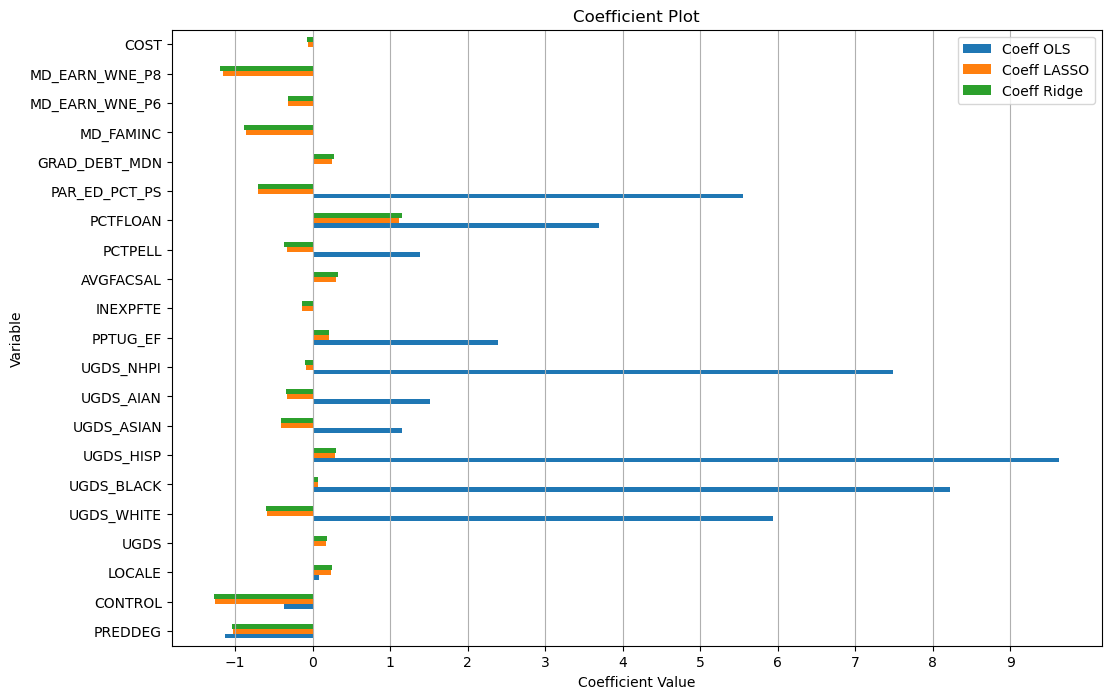

In [9]:
# Set index of df_results as variable names
df_results.set_index('Variable', inplace=True)

# Generate coefficient plot for df_results
df_results.plot(kind='barh', figsize=(12, 8))

# Add x-axis label
plt.xlabel('Coefficient Value')

# Add y-axis label
plt.ylabel('Variable')

# Add title
plt.title('Coefficient Plot')

# Keep x-axis grid
plt.grid(axis='x')

# Set range for plotting x-axis ticks
plt.xticks(range(-1, 10))

# Save figure in output path
plt.savefig(os.path.join(output_path,"coefficientplot.png"))

# Show plot
plt.show()